In [44]:
import pandas as pd
# Assuming the file u.data is located in your current directory or give the full path.
ratings = pd.read_csv('ml-100k/u.data', 
                      sep='\t',      # u.data is tab-separated
                      names=['userId', 'movieId', 'rating', 'timestamp'])

# Display the first few rows to confirm successful loading.
print(ratings.head())

   userId  movieId  rating  timestamp
0     196      242       3  881250949
1     186      302       3  891717742
2      22      377       1  878887116
3     244       51       2  880606923
4     166      346       1  886397596


In [48]:
# Depending on the exact structure, you might need to provide column names.
# Sample column names can include: movieId, title, release_date, video_release_date, IMDb URL, and then genre flags.
import pandas as pd
column_names = ['movieId', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
                'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy',
                'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
                'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies = pd.read_csv('ml-100k/u.item', 
                     sep='|',  # Pipe-delimited
                     names=column_names,
                     encoding='latin-1')  # Some files use latin-1 encoding

print(movies.head())

   movieId              title release_date  video_release_date  \
0        1   Toy Story (1995)  01-Jan-1995                 NaN   
1        2   GoldenEye (1995)  01-Jan-1995                 NaN   
2        3  Four Rooms (1995)  01-Jan-1995                 NaN   
3        4  Get Shorty (1995)  01-Jan-1995                 NaN   
4        5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb_URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

   Adventure  Animation  Children's  ...  Fantasy  Film-Noir  Horror  Musical  \
0          0          1           1  ...        0          0       0        0   
1 

In [49]:
# Ensure the item/movie identifier columns match. In our u.data file we called it 'item_id'
# and in the movies DataFrame it is 'movie_id'. We join on these columns.

# Merge ratings with movies
merged_data = pd.merge(ratings, movies, left_on='movieId', right_on='movieId')

# Display the merged DataFrame (show a few columns for clarity)
print(merged_data[['userId', 'movieId', 'rating', 'title', 'release_date']].head())

   userId  movieId  rating                       title release_date
0     196      242       3                Kolya (1996)  24-Jan-1997
1     186      302       3    L.A. Confidential (1997)  01-Jan-1997
2      22      377       1         Heavyweights (1994)  01-Jan-1994
3     244       51       2  Legends of the Fall (1994)  01-Jan-1994
4     166      346       1         Jackie Brown (1997)  01-Jan-1997


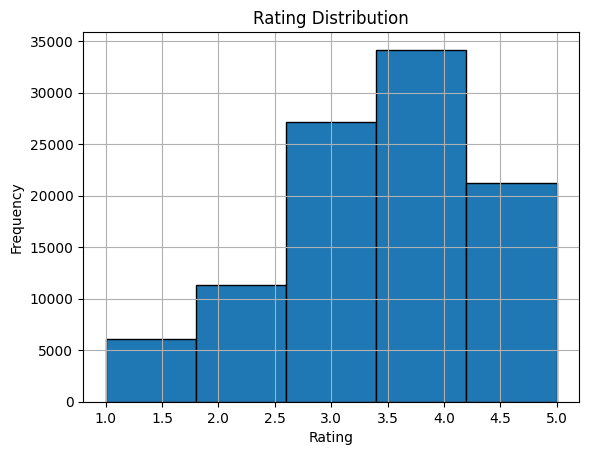

In [50]:
#Rating Distribution
import matplotlib.pyplot as plt

# Histogram of ratings
merged_data['rating'].hist(bins=5, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Distribution')
plt.show()

In [51]:
# Group by movie title and compute average rating and count of ratings
movie_stats = merged_data.groupby('title')['rating'].agg(['mean', 'count'])
# Filter for movies with a minimum number of ratings, e.g., more than 20 ratings for reliability
popular_movies = movie_stats[movie_stats['count'] >= 20]
top_rated = popular_movies.sort_values(by='mean', ascending=False)
print(top_rated.head(10))

                                                        mean  count
title                                                              
Close Shave, A (1995)                               4.491071    112
Schindler's List (1993)                             4.466443    298
Wrong Trousers, The (1993)                          4.466102    118
Casablanca (1942)                                   4.456790    243
Wallace & Gromit: The Best of Aardman Animation...  4.447761     67
Shawshank Redemption, The (1994)                    4.445230    283
Rear Window (1954)                                  4.387560    209
Usual Suspects, The (1995)                          4.385768    267
Star Wars (1977)                                    4.358491    583
12 Angry Men (1957)                                 4.344000    125


Drama          725
Comedy         505
Action         251
Thriller       251
Romance        247
Adventure      135
Children's     122
Crime          109
Sci-Fi         101
Horror          92
War             71
Mystery         61
Musical         56
Documentary     50
Animation       42
Western         27
Film-Noir       24
Fantasy         22
unknown          2
dtype: int64


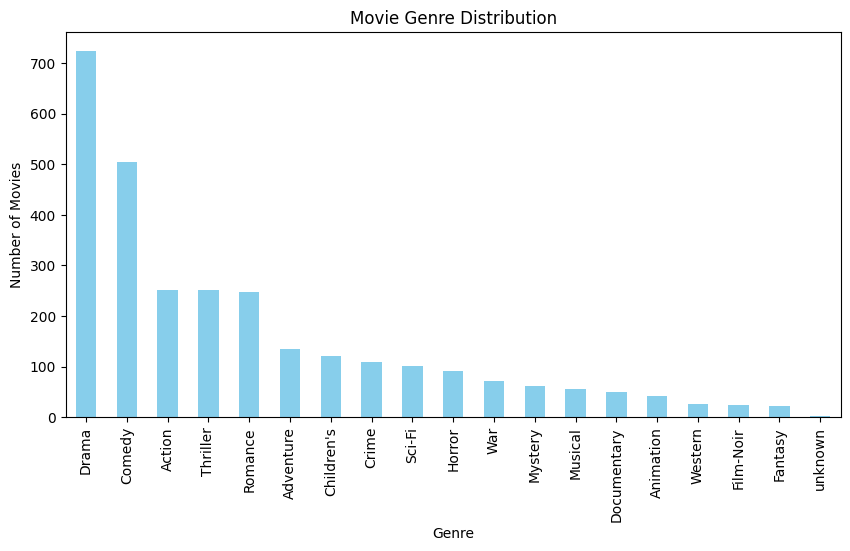

In [52]:
# List of genre columns from the u.item file (as defined in item_columns)
genre_columns = column_names[5:]  # skipping the first 5 columns

# Sum each genre column to get total count of movies in each genre
genre_counts = movies[genre_columns].sum().sort_values(ascending=False)
print(genre_counts)

# Plot the genre distribution
genre_counts.plot(kind='bar', figsize=(10,5), color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Movie Genre Distribution')
plt.show()


In [53]:
# Combine genre columns into a single string for each movie
movies['genre_text'] = movies[genre_columns].apply(
    lambda row: ' '.join([genre for genre in genre_columns if row[genre] == 1]),
    axis=1
)

print(movies[['title', 'genre_text']].head())

               title                   genre_text
0   Toy Story (1995)  Animation Children's Comedy
1   GoldenEye (1995)    Action Adventure Thriller
2  Four Rooms (1995)                     Thriller
3  Get Shorty (1995)          Action Comedy Drama
4     Copycat (1995)         Crime Drama Thriller


In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(movies['genre_text'])

In [55]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [56]:
# Reset index so we can find movies by title
movies = movies.reset_index()


In [57]:

# Build a reverse map of movie titles to indices
title_to_index = pd.Series(movies.index, index=movies['title'])

def recommend_movies(title, top_n=5):
    if title not in title_to_index:
        print("Movie not found in dataset.")
        return

    idx = title_to_index[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]  # skip the movie itself

    movie_indices = [i[0] for i in sim_scores]
    return movies[['title', 'genre_text']].iloc[movie_indices]

# Example usage
recommendations = recommend_movies("Toy Story (1995)")
print(recommendations)

                                      title                   genre_text
421  Aladdin and the King of Thieves (1996)  Animation Children's Comedy
101                  Aristocats, The (1970)         Animation Children's
403                        Pinocchio (1940)         Animation Children's
624          Sword in the Stone, The (1963)         Animation Children's
945           Fox and the Hound, The (1981)         Animation Children's
